# **CITS5017 Deep Learning Project 2**

#### Long Qin (23829101)

# Libraries

In [174]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tensorflow import keras

# 0. Key Utility Functions 

In [175]:
def load_data(picklefile):
     f = open(picklefile, "rb")
     dict = pickle.load(f)
     f.close()
     return dict["Perth_Airport"], dict["Perth_Metro"]
     
PerthA_df, PerthM_df = load_data("temperatures.pkl")

In [176]:
def split_data(df, inputs_length, targets_length, batch_size=32, shuffle=True, seed=42):
     # an inner function to do the splitting
     def split_inputs_and_targets(tf_ds):
         return tf_ds[:, :-targets_length], tf_ds[:,-targets_length:]
     
     if batch_size ==-1:
         batch_size = df.shape[0]
 
     return tf.keras.utils.timeseries_dataset_from_array(
         tf.convert_to_tensor(df, dtype=tf.float32),
         targets = None,
         sequence_length = inputs_length + targets_length,
         batch_size = batch_size,
         shuffle = shuffle,
         seed = seed
     ).map(split_inputs_and_targets)

In [177]:
def split_XY_from_dataset(dataset):
    # provided by unit coordinator to split data into x and y
    out = list(map(lambda lam: (lam[0], lam[1]), dataset))
    X = tf.concat( [out[i][0] for i in range(len(out))], axis = 0 )
    y = tf.concat( [out[i][1] for i in range(len(out))], axis = 0 )
    return X, y

In [178]:
def prepare_datasets(PerthA_df, PerthM_df, inputs_length=72, targets_length=12):
    train_ds = split_data(PerthA_df, inputs_length, targets_length, batch_size=32, shuffle=True)
    val_ds = split_data(PerthM_df.loc['1994-01':'2013-12'], inputs_length, targets_length, batch_size=-1, shuffle=False)
    test_ds = split_data(PerthM_df.loc['2014-01':], inputs_length, targets_length, batch_size=-1, shuffle=False)
    return train_ds, val_ds, test_ds

In [179]:
def plot_learning_curves(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='green')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
    plt.title('Mean Squared Error')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('Loss-MSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE',color='green')
    plt.plot(history.history['val_mae'], label='Validation MAE', color='red')
    plt.title('Mean Absolute Error')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.tight_layout() 
    plt.show()

In [180]:
def display_temperatures(X, y=None, predictions=None):
    """
    Handle generated temperature sequences, actual data (Input and target), and predictions.

    Parameters:

    If only one parameter, it represents the generated temperature sequence.
    If two parameters, they represent the Input sequence and Target sequence.
    If three parameters, they represent the Input sequence, Target sequence, and Predicted sequence.
    """
    if y is None:
        synthesized_sequences = X
        num_sequences = min(6, generated_sequences.shape[0])
    
    # create 2x3 subplot
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        fig.suptitle("Synthesized Temperature Sequences", fontsize=16)
        
        # Iterate over the generated sequence and plot.
        for i, ax in enumerate(axes.flat[:num_sequences]):
            sequence = generated_sequences[i, :, 0]  
            ax.plot(sequence, "g.-")
            ax.set_title(f'Sequence {i+1}')
            ax.set_xlabel('Month')
            ax.set_ylabel('Temperature (°C)')
            
            # flexiable y axis range
            mean_temp = np.mean(sequence)
            ax.set_ylim(mean_temp - 15, mean_temp + 15)
        
        plt.tight_layout()
        plt.show()
    
    else:     # deal with real data  for  2 or 3 parameters  
        fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)   
        
        for i, ax in enumerate(axes):
            idx = np.random.randint(X.shape[0])
            
            time_steps_input = np.arange(X.shape[1])
            ax.plot(time_steps_input, X[idx, :, 0], label='Min Temp (Input)', color='cyan', marker='.')
            ax.plot(time_steps_input, X[idx, :, 1], label='Max Temp (Input)', color='red', marker='.')
            
            time_steps_target = np.arange(X.shape[1], X.shape[1] + y.shape[1])
            
            ax.plot(time_steps_target, y[idx, :, 0], label='Min Temp (Target)', color='blue', marker='.', markersize=10)
            ax.plot(time_steps_target, y[idx, :, 1], label='Max Temp (Target)', color='green', marker='.', markersize=10)
            
            if predictions is not None:
                ax.plot(time_steps_target, predictions[idx, :, 0], label='Min Temp (Predicted)', 
                        color='cyan', linestyle='--', marker='x', markersize=10)
                ax.plot(time_steps_target, predictions[idx, :, 1], label='Max Temp (Predicted)', 
                        color='red', linestyle='--', marker='x', markersize=10)
            
            ax.set_title(f'Sequence {i+1}')
            ax.set_xlabel('Time Steps')
            if i == 0:
                ax.set_ylabel('Temperature (°C)')
            ax.grid(True, linestyle=':', alpha=0.6)
            
            ax.set_xlim(time_steps_input[0] - 1, time_steps_target[-1] + 1)
    
    handles, labels = ax.get_legend_handles_labels()       # Set the legend
    fig.legend(handles, labels, loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.05))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  
    plt.show()


# 1. Data split and visualization

## 1.1 Set parameters and Prepare datasets

In [181]:
# Set parameters
inputs_length = 72 
targets_length = 12 
# parpare the data
train_ds, val_ds, test_ds = prepare_datasets(PerthA_df, PerthM_df, inputs_length, targets_length)

## 1.2 Display temperatures 

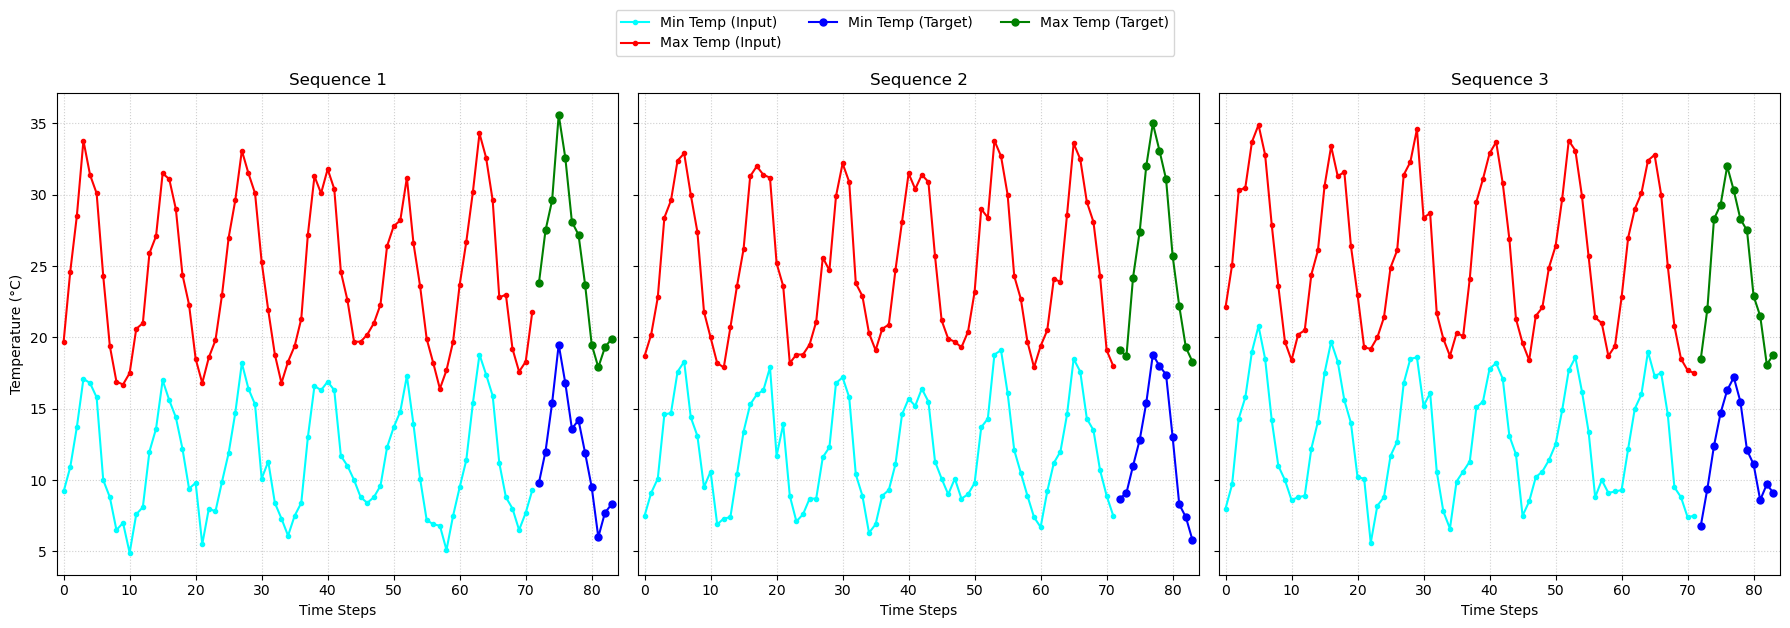

In [182]:
# Display temperatures for training dataset
for X_train, y_train in train_ds.take(1):
    display_temperatures(X_train, y_train)

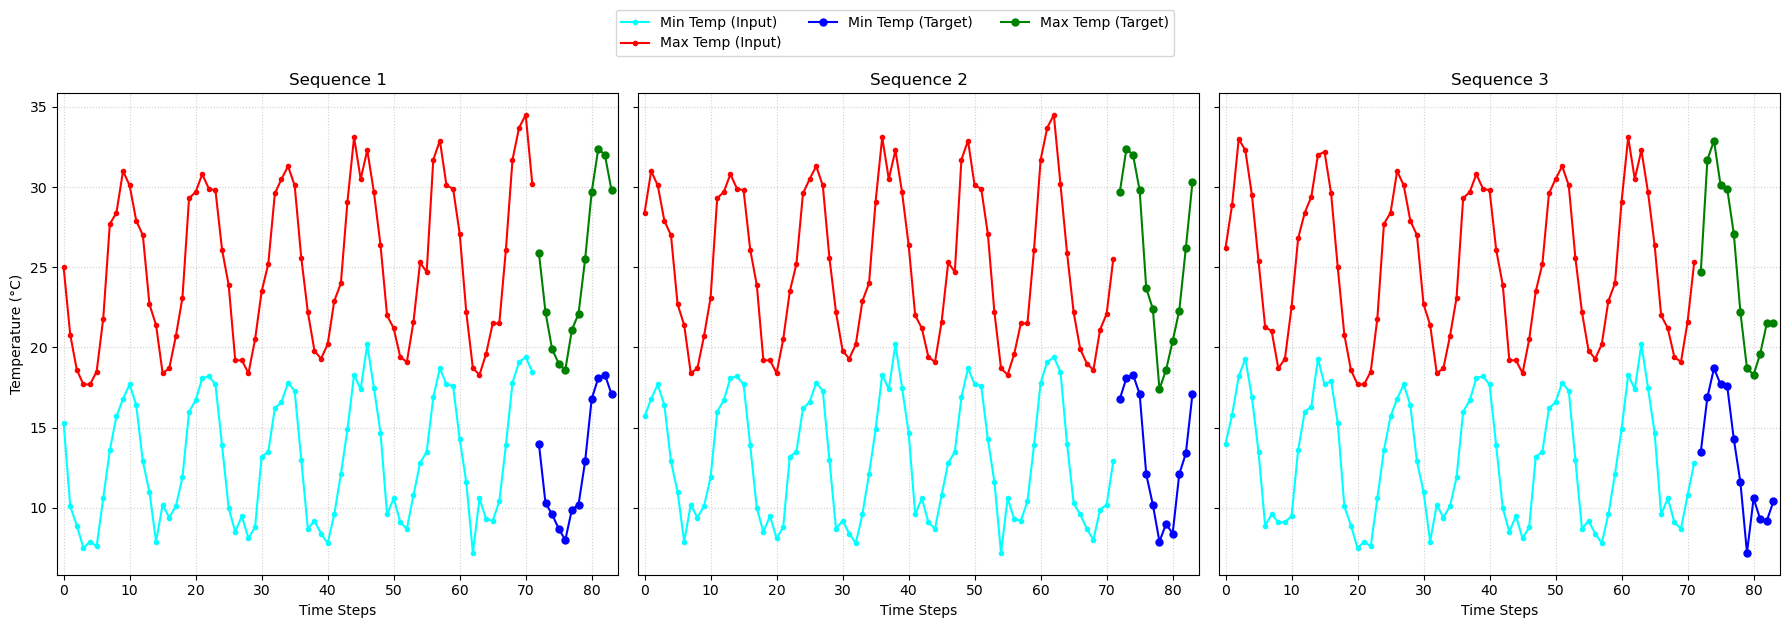

In [183]:
# Display temperatures for test dataset
for X_test, y_test in test_ds.take(1):
    display_temperatures(X_test, y_test)

# 2. Model 1

## 2.1 Design 2-layer GRU network 

### Change the activation function to 'relu', as the default tanh(-1,1) is not suitable for temperatures in Perth

In [184]:
def create_model(inputs_length, targets_length):
    inputs = tf.keras.layers.Input(shape=(None, 2))  # Define the input shape here
    first_GRU = tf.keras.layers.GRU(16, return_sequences=True, activation='relu')(inputs)  # change the activate function to relu
    second_GRU = tf.keras.layers.GRU(16, activation='relu')(first_GRU)
    dense_layer = tf.keras.layers.Dense(targets_length * 2)(second_GRU)
    outputs = tf.keras.layers.Reshape((targets_length, 2))(dense_layer)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)  # Define the model with inputs and outputs
    return model

In [185]:
def train_model(model, train_ds, val_ds, epochs=50):
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=0)
    return history

In [186]:
def model_1_pipeline(PerthA_df, PerthM_df, inputs_length=72, targets_length=12):
    # Prepare datasets
    train_ds, val_ds, test_ds = prepare_datasets(PerthA_df, PerthM_df, inputs_length, targets_length)
    
    # Create model
    model = create_model(inputs_length, targets_length)
    
    # Train model
    history = train_model(model, train_ds, val_ds)
    
    # Evaluate on test dataset
    _, test_mae = model.evaluate(test_ds,verbose=0)
    
    X_test, y_test = split_XY_from_dataset(test_ds)
    predictions = model.predict(X_test,verbose=0)

    mae = round(test_mae, 2)
    
    return model, history, mae, X_test, y_test, predictions

## 2.2 Train the model and output the results

In [187]:
# Set parameters
inputs_length_1 = 72 
targets_length_1 = 12 

In [188]:
# call the model_1_pipeline
model_1, history_1, mae_1, X_test_1, y_test_1, predictions_1 = model_1_pipeline(PerthA_df, PerthM_df, inputs_length=inputs_length_1, targets_length=targets_length_1)

## 2.3 Output 
### Model architecture 
### Learning curves,
### Temperature sequences
### MAE

Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_69 (InputLayer)          │ (None, None, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_42 (GRU)                         │ (None, None, 16)            │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_43 (GRU)                         │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_64 (Dense)                     │ (None, 24)                  │             408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_27 (Reshape)                 │ (None, 12, 2)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,002 (35.17 KB)

 Trainable params: 3,000 (11.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,002 (23.45 KB)

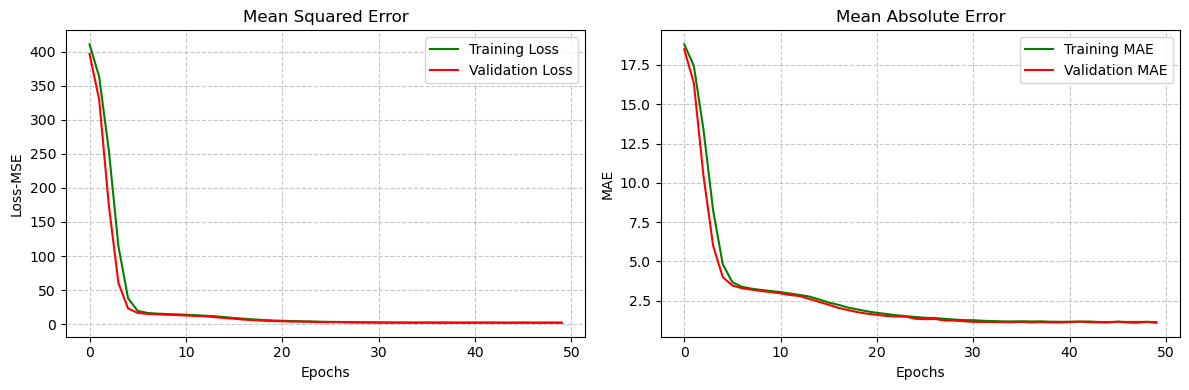

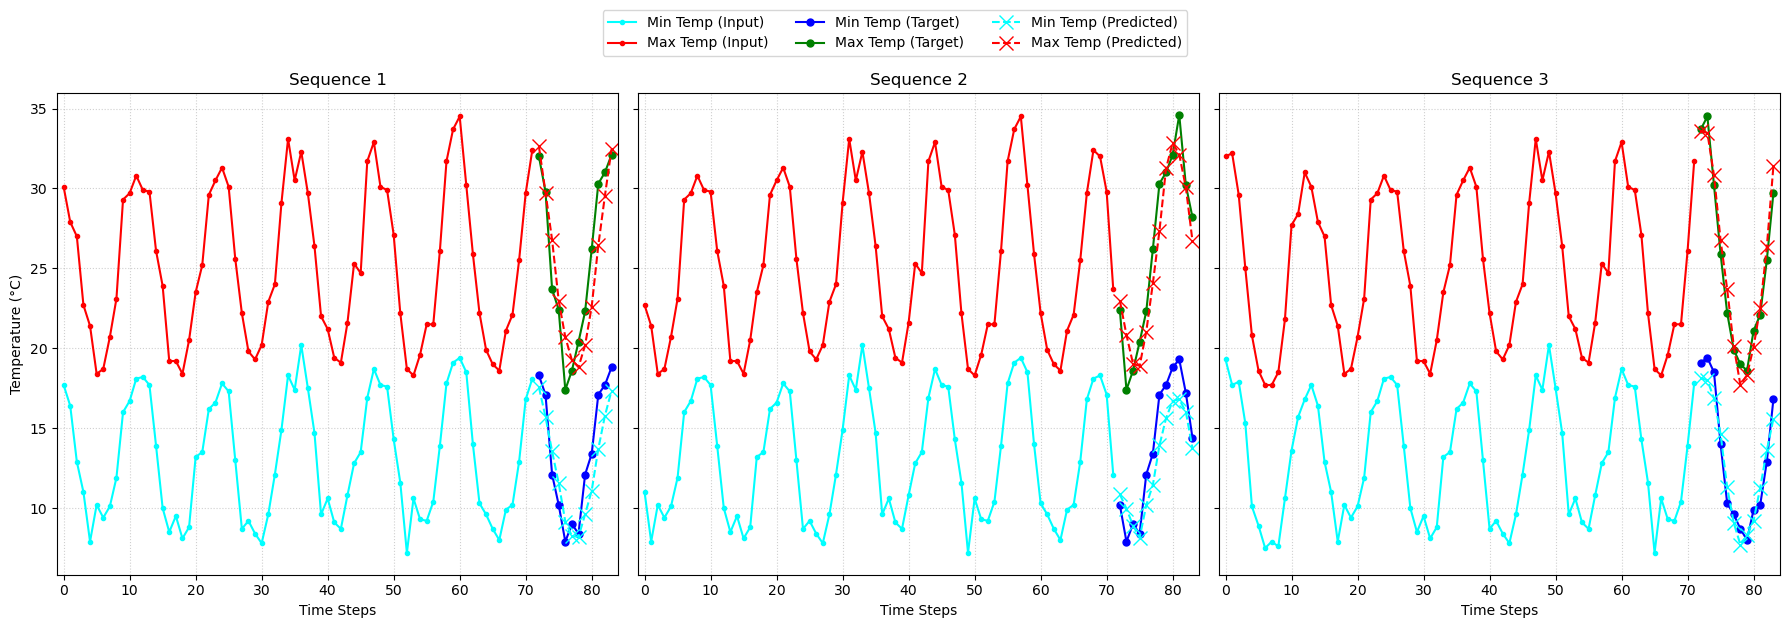


Model_1 (Prediction length = 12)  MAE :1.17



In [189]:
model_1.summary()
plot_learning_curves(history_1)
display_temperatures(X_test_1, y_test_1, predictions_1)
print(f"\nModel_1 (Prediction length = 12)  MAE :{mae_1}\n")

# 3. Model 2

## 3.1 Model_2_1  (predict 1 month only)

### 3.1.1 Prepare the data and create the model

In [190]:
# Set parameters
inputs_length_2 = 72 
targets_length_2_1 = 1  

In [191]:
# prepare the data
train_ds_2, val_ds_2, test_ds_2 = prepare_datasets(PerthA_df, PerthM_df, inputs_length_2, targets_length_2_1)

In [192]:
# create the model and summary architecture
model_2 = create_model(inputs_length_2, targets_length_2_1)
model_2.summary()

Model: "functional_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_70 (InputLayer)          │ (None, None, 2)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_44 (GRU)                         │ (None, None, 16)            │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_45 (GRU)                         │ (None, 16)                  │           1,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_65 (Dense)                     │ (None, 2)                   │              34 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_28 (Reshape)                 │ (None, 1, 2)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,626 (10.26 KB)

 Trainable params: 2,626 (10.26 KB)

 Non-trainable params: 0 (0.00 B)

### 3.1.2 Train the model and plot the learning curves

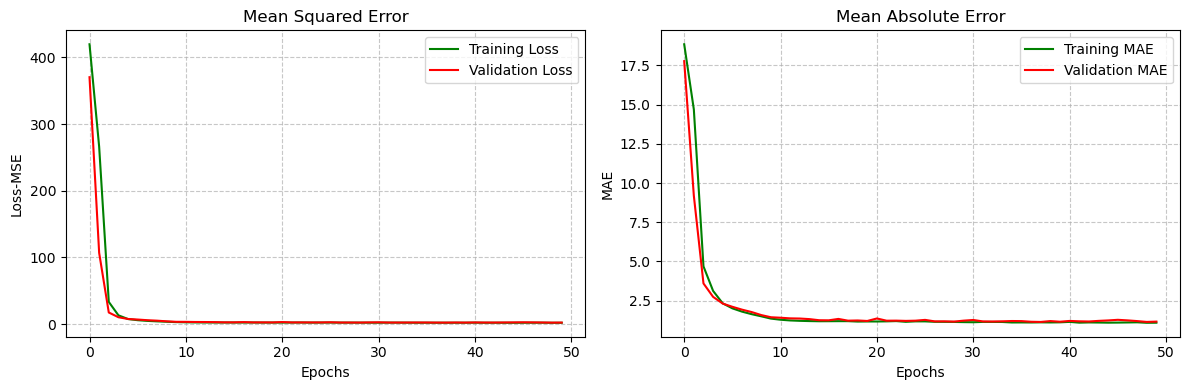

In [193]:
# train the model to predict only 1 month
history_2 = train_model(model_2, train_ds_2, val_ds_2)
# Plot learning curves
plot_learning_curves(history_2)

### 3.1.3 Calculate the MAE - only 1 month

In [194]:
# Evaluate on test dataset
_, mae_2_1 = model_2.evaluate(test_ds_2,verbose=0)
print(f"\nModel_2 (Observe 72 steps and Predict 1 step) MAE: {mae_2_1:.2f}\n")



Model_2 (Observe 72 steps and Predict 1 step) MAE: 1.21



### 3.1.4 Display_temperatures

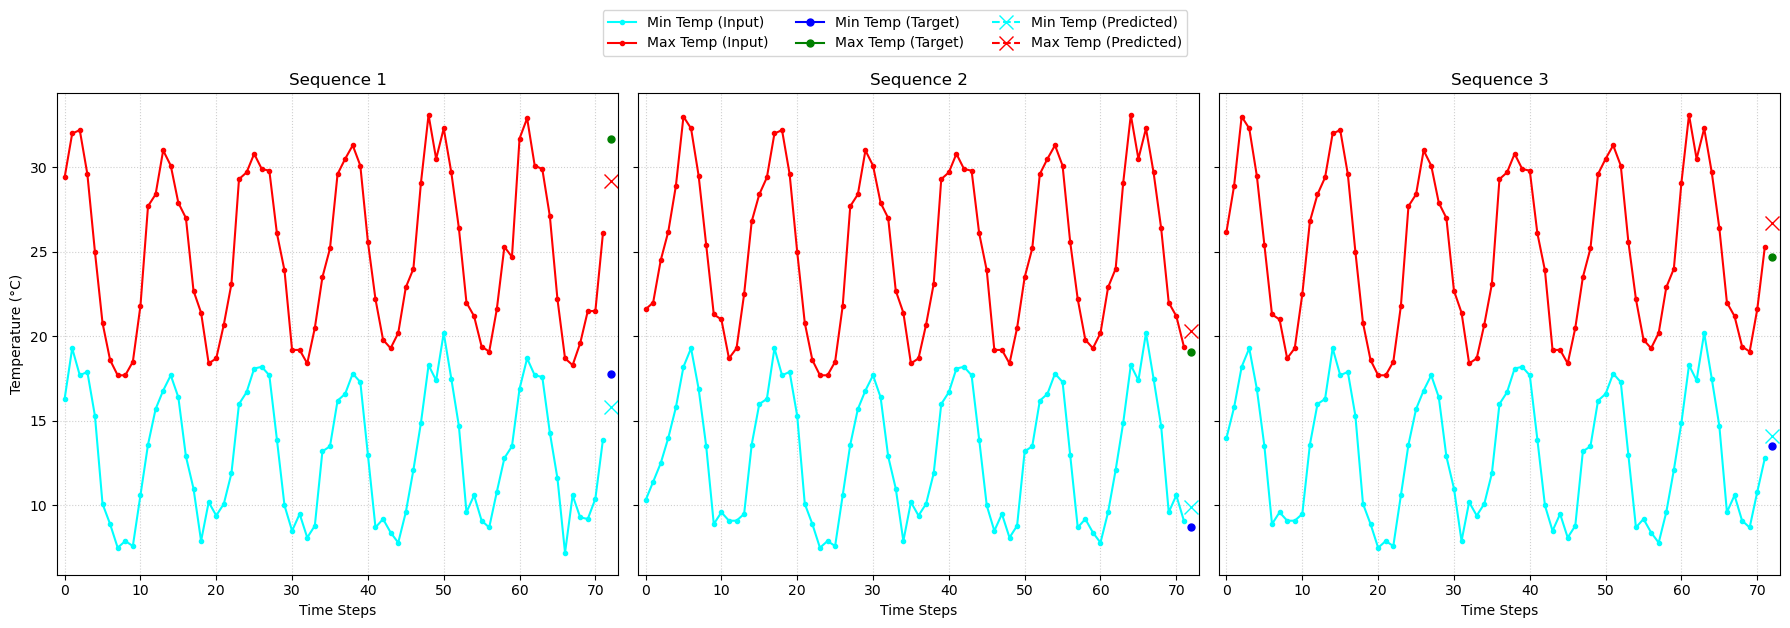

In [195]:
for batch in test_ds_2.take(1): # look into the first (and only) minibatch
   X_test_2, y_test_2 = batch
# for X_test, y_test in test_ds.take(1):
predictions_2_1 = model_2.predict(X_test_2,verbose=0)
# call the display_temperatures to plot temperatures with 1 predicted month.
display_temperatures(X_test_2, y_test_2, predictions_2_1)

## 3.2   Model_2   (Predict 12 months)

### 3.2.1 Model 2 funtions 

In [196]:
def predict_multiple_steps(model, X, targets_length):
    seq_length, n_features = X.shape[1], X.shape[2]
    predictions = np.zeros((X.shape[0], targets_length, 2))
    
    for i in range(targets_length):
        current_pred = model.predict(X,verbose=0)
        predictions[:, i, :] = current_pred[:, 0, :]
        
        # update X for the next round
        if i < targets_length - 1:
            X = np.concatenate([X[:, 1:, :], current_pred], axis=1)
            
    return predictions


#### Explaination:
Drop the 1st month's (the oldest month's) temperature to keep the inputs_length constant.

In [197]:
def evaluate_model_2(model, original_test_ds, targets_length):
    X_test, y_test = split_XY_from_dataset(original_test_ds)
 
    # call the function to predict the following steps
    predictions = predict_multiple_steps(model, X_test, targets_length)
    
    # calcuate the MAE
    mae = round(np.mean(np.abs(y_test - predictions)), 2)
    
    return mae, X_test, y_test, predictions


### model_2_pipeline

In [198]:
def model_2_pipeline(PerthA_df, PerthM_df, inputs_length, targets_length):
    # targets_length = 1, base model only predict 1 step
    train_ds, val_ds, test_ds = prepare_datasets(PerthA_df, PerthM_df, inputs_length, targets_length=1)
    
    #create and train the base model  (inputs_length/targets_length=1)
    model = create_model(inputs_length, targets_length=1)
    history = train_model(model, train_ds, val_ds)

    # Complete target_length，Only used for testing
    _, _, original_test_ds = prepare_datasets(PerthA_df, PerthM_df, inputs_length, targets_length)
    
    # use the  original_test_ds to calculate the MAE...
    mae, X_test, y_test, predictions = evaluate_model_2(model, original_test_ds, targets_length)
    
    return model, history, mae, X_test, y_test, predictions

### 3.2.2 Call the `model_2_pipeline` to get the needed results

In [199]:
# call  model_2_pipeline
_, _, mae_2, X_test_2, y_test_2, predictions_2 = model_2_pipeline(PerthA_df, PerthM_df, 72, 12)

#### Explaination:
* I did not explicitly receive the `model` since model summarywas already addressed in `Section 3.1`. 
* Additionally, the `history` used for plotting the learning curves was also discussed in `Section 3.1`. 
* `maes_2`, `X_test_2`, `y_test_2`, `predictions_2` will be used imeediately.

### 3.2.3 Display_temperatures and print the MAE (12 months)

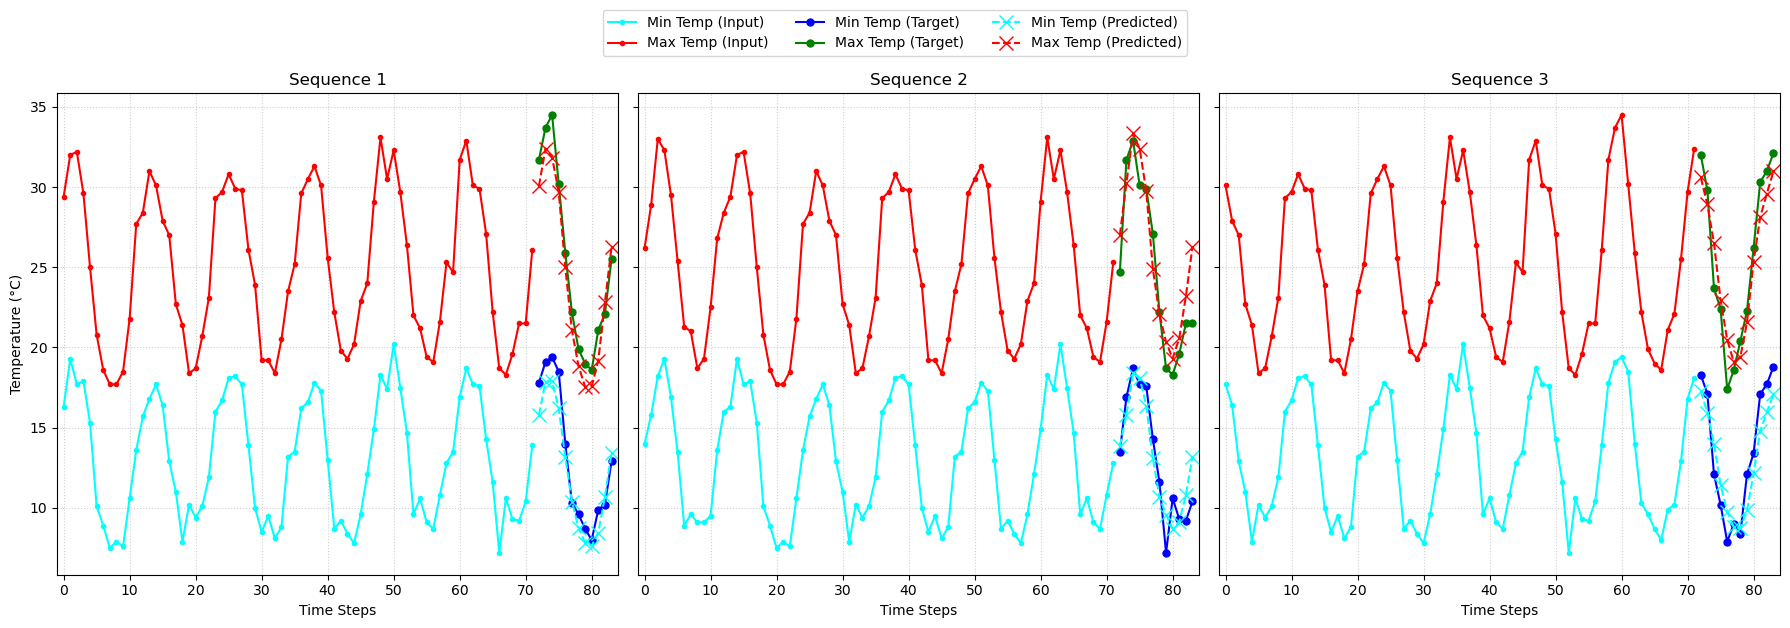

In [200]:
display_temperatures(X_test_2, y_test_2, predictions_2)

In [201]:
print(f"\nModel_2 (12-month Prediction) MAE: {mae_2:.2f}\n")


Model_2 (12-month Prediction) MAE: 1.26



# 4. Model 3

## 4.1 Define the model architecture and training functions

In [202]:

def create_encoder_decoder_model(inputs_length, targets_length):    
    # encoder
    encoder_inputs = tf.keras.layers.Input(shape=(None, 2))
    encoder_gru1 = tf.keras.layers.GRU(16, activation='relu', return_sequences=True, return_state=True) # state return and sequence return as first layer
    encoder_gru2 = tf.keras.layers.GRU(16, activation='relu', return_state=True) # Second GRU layer with state return, no return and sequence
    x, encoder_state1 = encoder_gru1(encoder_inputs)
    _, encoder_state2 = encoder_gru2(x)
    
    # decoder
    decoder_inputs = tf.keras.layers.Input(shape=(None, 2))
    decoder_gru1 = tf.keras.layers.GRU(16, activation='relu', return_sequences=True)
    decoder_gru2 = tf.keras.layers.GRU(16, activation='relu', return_sequences=True)
    x = decoder_gru1(decoder_inputs,initial_state = encoder_state1)      # Initialize decoder first GRU with encoder state
    decoder_outputs = decoder_gru2(x, initial_state = encoder_state2)    # Initialize decoder second GRU with encoder state
    decoder_dense = tf.keras.layers.Dense(2) 
    decoder_outputs = decoder_dense(decoder_outputs)

    # connect encoder and decoder
    model = tf.keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
     
    return model


In [203]:
def train_encoder_decoder_model(model, train_ds, val_ds, epochs=50):
    X_train, y_train =  split_XY_from_dataset(train_ds)
    X_val, y_val =  split_XY_from_dataset(val_ds)

    encoder_input_train = X_train[:, :-1, :]     #shifted by 1
    decoder_target_train = y_train
    decoder_input_train = np.zeros_like(y_train)
    decoder_input_train[:, 0, :] = X_train[:, -1, :]
    decoder_input_train[:, 1:, :] = y_train[:, :-1, :]

    encoder_input_val = X_val[:, :-1, :]
    decoder_target_val = y_val
    decoder_input_val = np.zeros_like(y_val)
    decoder_input_val[:, 0, :] = X_val[:, -1, :]
    decoder_input_val[:, 1:, :] = y_val[:, :-1, :]
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    history = model.fit(
        [encoder_input_train, decoder_input_train],  
        decoder_target_train,                        
        validation_data=(
            [encoder_input_val, decoder_input_val], 
            decoder_target_val                       
        ),
        epochs=epochs,
        batch_size=32,
        verbose=0                 #  0
    )
    return history

#### Prediction for model_3 - step by step

In [204]:
def predict_step_by_step(model, encoder_input, decoder_input, output_seq_len):
    batch_size = encoder_input.shape[0]
    predictions = np.zeros((batch_size, output_seq_len, 2))  
    
    for i in range(output_seq_len):
        # use current encoder_input and decoder_input to predict
        step_pred = model.predict([encoder_input, decoder_input],verbose=0)
        
        # store the predicted results
        predictions[:, i, :] = step_pred[:, i, :]
        
        if i + 1 < output_seq_len:
            # update decoder_input for the prediction of next step
            decoder_input[:, i+1, :] = step_pred[:, i, :]
    
    return predictions

####  Evaluate_model_3  

In [205]:
def evaluate_model_3(model, test_ds, targets_length):
    # split into x and  y
    X_test, y_test = split_XY_from_dataset(test_ds)
    
    # test encoder data , shift by 1
    encoder_input_test = X_test[:, :-1, :]    ## Shifted by 1
    
    # decoder data input
    decoder_input_test = np.zeros((X_test.shape[0], targets_length, 2))
    decoder_input_test[:, 0, :] = X_test[:, -1, :]
    
    # call the function to predict step by step
    predictions = predict_step_by_step(model, encoder_input_test, decoder_input_test, targets_length)
    
    # calculate the MAE
    mae = round(np.mean(np.abs(y_test - predictions)), 2)
    
    return mae,  X_test, y_test, predictions


####  Based on the above functions I build the `model_3_pipeline`

In [206]:
def model_3_pipeline(PerthA_df, PerthM_df, inputs_length=72, targets_length=12):
    """
    Complete pipeline for Model 3, including dataset preparation, model training, and evaluation.

    Parameters:
    PerthA_df -- Dataset A
    PerthM_df -- Dataset M
    inputs_length -- Length of input sequence (e.g., 72)
    targets_length -- Length of target sequence to predict (e.g., 12)
    
    Returns:
    mae_3 -- Mean Absolute Error of the model
    X_test_3 -- Input features of the test set
    y_test_3 -- True labels of the test set
    predictions_3 -- Predictions made by the model
    """
    # 1. train, val and test dataset
    train_ds, val_ds, test_ds = prepare_datasets(PerthA_df, PerthM_df, inputs_length, targets_length)
    
    # 2. create encoder decodr model
    model = create_encoder_decoder_model(inputs_length, targets_length)
    
    # 3. train the model
    history = train_encoder_decoder_model(model, train_ds, val_ds)
    
    # 4. evaluate the model , predict step by step
    mae, X_test, y_test, predictions = evaluate_model_3(model, test_ds, targets_length)
    
    return model, history, mae, X_test, y_test, predictions


## 4.2 Call the function, train the model and get teh data needed

In [207]:
# Set parameters
inputs_length_3 = 72 
targets_length_3= 12

In [208]:
#  call  model_3_pipeline
model_3, history_3, mae_3, X_test_3, y_test_3, predictions_3 =  model_3_pipeline(PerthA_df, PerthM_df, inputs_length=72, targets_length=12)


## 4.3 Output 
### Model 3 architecture 
### Learning curves
### Temperature sequences
### MAE

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_72 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_73 (InputLayer)   │ (None, None, 2)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_48 (GRU)                  │ [(None, None, 16), (None, │             960 │ input_layer_72[0][0]       │
│                               │ 16)]                      │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_50 (GRU)                  │ (None, None, 16)          │             960 │ input_layer_73[0][0],      │
│                               │                           │                 │ gru_48[0][1]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_49 (GRU)                  │ [(None, 16), (None, 16)]  │           1,632 │ gru_48[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gru_51 (GRU)                  │ (None, None, 16)          │           1,632 │ gru_50[0][0], gru_49[0][1] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_67 (Dense)              │ (None, None, 2)           │              34 │ gru_51[0][0]               │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 15,656 (61.16 KB)

 Trainable params: 5,218 (20.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,438 (40.78 KB)

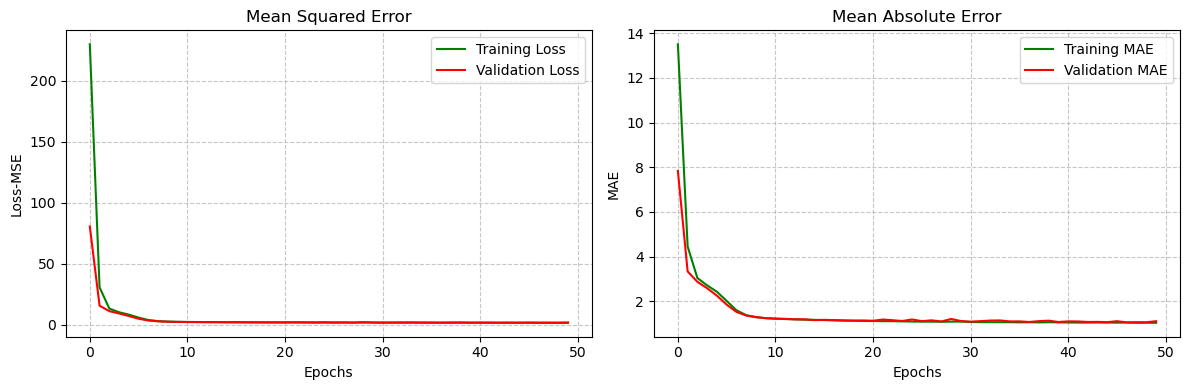

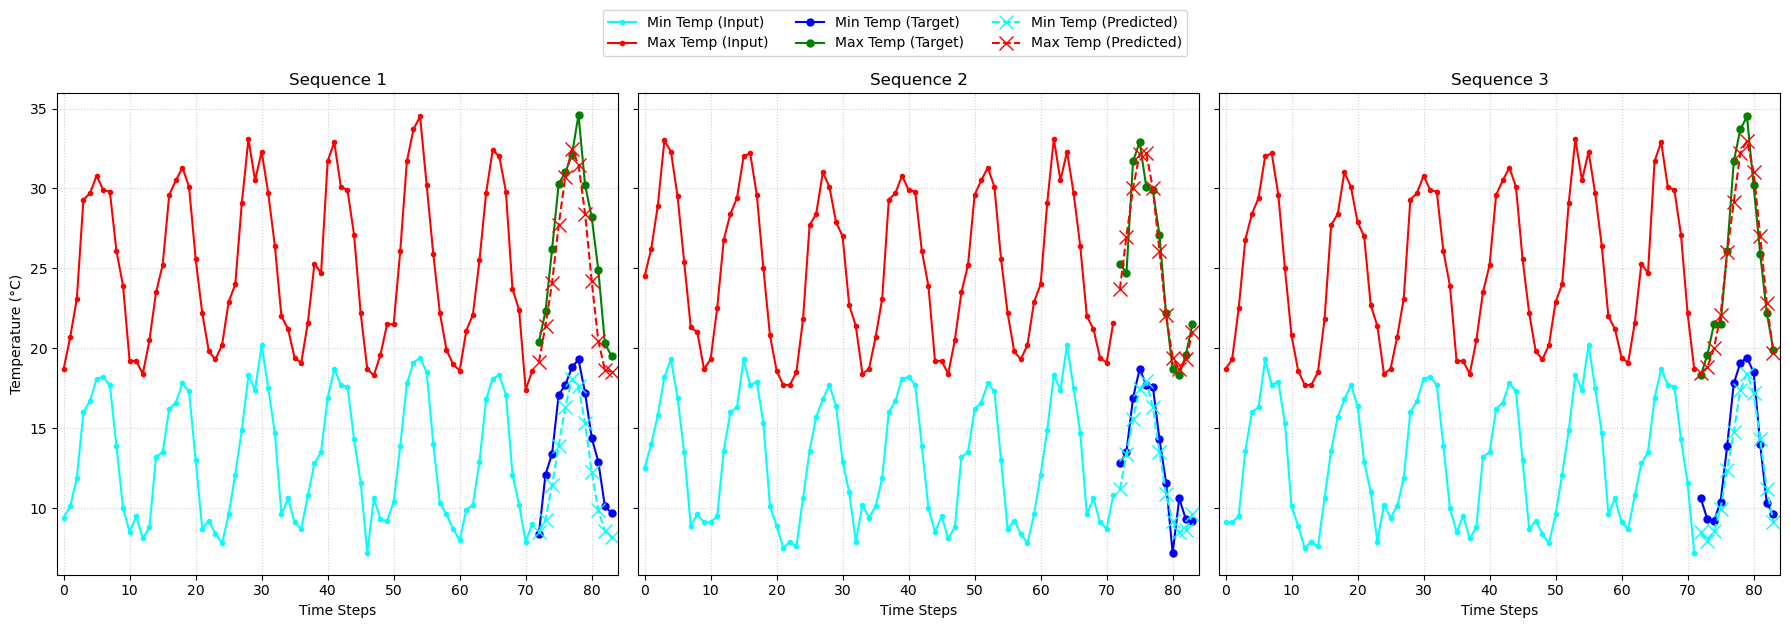

Test MAE Model_3: 1.24


In [209]:
model_3.summary()
plot_learning_curves(history_3)
display_temperatures(X_test_3, y_test_3, predictions_3)
print(f"Test MAE Model_3: {mae_3:.2f}")

# 5. Comparison for different target lengths

## 5.1 Define a dic to store MAEs for differnt models through various prediction length

In [210]:
results = {
    12: {'Model_1_MAE': mae_1, 'Model_2_MAE': mae_2, 'Model_3_MAE': mae_3}
}

length_combinations = [(66, 18), (60, 24), (54, 30), (48, 36)]

for inputs_length, targets_length in length_combinations:
    print(f"\nExperimenting with inputs_length={inputs_length}, targets_length={targets_length}...")
    
    # Model 1, we only need mae here
    _, _, mae_1, _, _, _ = model_1_pipeline(PerthA_df, PerthM_df, inputs_length, targets_length)
    results[targets_length] = {'Model_1_MAE': mae_1}
    
    # Model 2,
    _, _, mae_2, _, _, _ = model_2_pipeline(PerthA_df, PerthM_df, inputs_length, targets_length)
    results[targets_length]['Model_2_MAE'] = mae_2
    
    # Model 3
    _, _, mae_3, _, _, _ = model_3_pipeline(PerthA_df, PerthM_df, inputs_length, targets_length)
    results[targets_length]['Model_3_MAE'] = mae_3

print("\nAll different prediction lengths experiments complete!")



Experimenting with inputs_length=66, targets_length=18...

Experimenting with inputs_length=60, targets_length=24...

Experimenting with inputs_length=54, targets_length=30...

Experimenting with inputs_length=48, targets_length=36...

All different prediction lengths experiments complete!


## 5.2 Define the plot funtion and plot the results

In [211]:
def plot_mae_results(results):
    prediction_lengths = list(results.keys())
    models = list(next(iter(results.values())).keys())
    
    plt.figure(figsize=(10, 6))
    
    for model in models:
        mae_values = [results[length][model] for length in prediction_lengths]
        plt.plot(prediction_lengths, mae_values, marker='o', label=model)

    plt.xlabel('Prediction Length')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('Model Performance Comparison')
    plt.legend()
    plt.grid(True)

    plt.show()


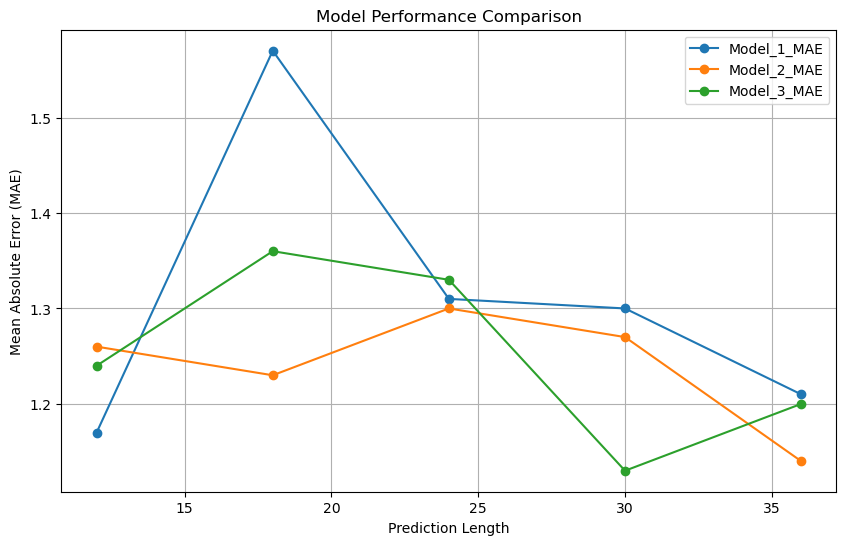

In [212]:
plot_mae_results(results)

- To be fair for all the models, I recreated and retrained all the three models.
- Since test set is `very small` (only 45 sequences in total). 
- We can not see a clearly performance drop down as the prediction length increases.

# 5. Task for part (ii)

## 5.1 Model Design for VAE

In [213]:
class Sampling(tf.keras.layers.Layer):
        def call(self, inputs):
            mean, logvar = inputs           # Unpack the mean and log variance from inputs
            batch = tf.shape(mean)[0]       # Get the batch size
            dim = tf.shape(mean)[1]
            epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
            # KL divergence loss-Encourages latent space to follow standard normal distribution
            # Balances reconstruction error and distribution matching
            kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar), axis=-1)
            self.add_loss(kl_loss)
            return mean + tf.exp(0.5 * logvar) * epsilon
    
 
def create_encoder(input_length, feature_dim, codings_size):
    encoder_inputs = tf.keras.Input(shape=[input_length, feature_dim])
    x = tf.keras.layers.Conv1D(32, 3, activation="relu", padding="same")(encoder_inputs)
    x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same")(x)    # activation function relu
    x = tf.keras.layers.Flatten()(x)
    codings_mean = tf.keras.layers.Dense(codings_size)(x)
    codings_log_var = tf.keras.layers.Dense(codings_size)(x)
    codings = Sampling()([codings_mean, codings_log_var])
    variational_encoder = tf.keras.Model(
        inputs=encoder_inputs, outputs=[codings_mean, codings_log_var, codings])
    return variational_encoder

def create_decoder(input_length, codings_size):
    decoder_inputs = tf.keras.Input(shape=[codings_size])
    x = tf.keras.layers.Dense(input_length * 8, activation="relu")(decoder_inputs)  ###    
    x = tf.keras.layers.Reshape([input_length,8])(x)                                    ##  
    # Transpose convolutional layers to reconstruct the output
    x = tf.keras.layers.Conv1DTranspose(32, 3, activation="relu", padding="same")(x)
    outputs = tf.keras.layers.Conv1D(1, 3, padding="same")(x)
    variational_decoder = tf.keras.Model(inputs=decoder_inputs, outputs=outputs)
    return variational_decoder

def create_vae(encoder, decoder, input_length, feature_dim):
    vae_inputs = tf.keras.Input(shape=[input_length, feature_dim])
    _, _, codings = encoder(vae_inputs)
    reconstructions = decoder(codings)
    vae = tf.keras.Model(inputs=vae_inputs, outputs=reconstructions)
    return vae

def compile_and_train_vae(vae, X_train_vae, X_val_vae, epochs=75, batch_size=32):
    vae.compile(optimizer='nadam', loss='mse', metrics=['mae'])
    history = vae.fit(X_train_vae, X_train_vae, epochs=epochs, batch_size=batch_size, 
                      validation_data=(X_val_vae, X_val_vae), verbose=0)
    return history

## 5.2 Train the VAE

In [214]:
def prepare_vae_data(PerthA_df, PerthM_df, inputs_length=84, targets_length=1):
    # olny  maximum temperature
    PerthA_df_max = PerthA_df[['Mean maximum temperature (°C)']]
    # PerthM_df  as val data for VAE
    PerthM_df_max = PerthM_df[['Mean maximum temperature (°C)']]
    
    # prepare the data
    train_ds_vae, val_ds_vae, _ = prepare_datasets(PerthA_df_max, PerthM_df_max, inputs_length, targets_length)
    
    X_train_vae,_ = split_XY_from_dataset(train_ds_vae)
    X_val_vae,_ = split_XY_from_dataset(val_ds_vae)
    
    return X_train_vae, X_val_vae

In [215]:
def vae_pipline(PerthA_df, PerthM_df, input_length=84, feature_dim=1, codings_size=24):
    # prepare data
    X_train_vae, X_val_vae = prepare_vae_data(PerthA_df, PerthM_df, input_length, feature_dim)
    
    #create encoder , decoder and VAE
    encoder = create_encoder(input_length, feature_dim, codings_size)
    decoder = create_decoder(input_length, codings_size)
    vae = create_vae(encoder, decoder, input_length, feature_dim)
    
    # compile and train VAE
    history = compile_and_train_vae(vae, X_train_vae, X_val_vae)
    
    return history, encoder, decoder, X_train_vae

#### set the parameters and call the  `vae_pipline`
- For the **codings_size**， experimented from  `2` to `48`.
- Finally, I selected `24`.

In [216]:
codings_size= 24
input_length_vae = 84
feature_dim = 1

In [217]:
# call the pipeline
history_vae, encoder_vae, decoder_vae, X_train_vae = vae_pipline(PerthA_df, PerthM_df, input_length_vae, feature_dim=1, codings_size=24)

## 5.3 Plot the learning curves 

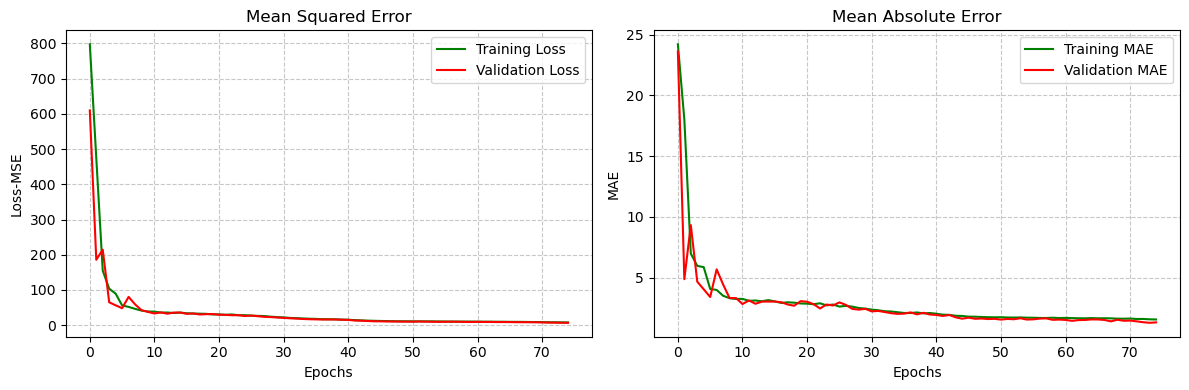

In [218]:
plot_learning_curves(history_vae)

### 5.4  Report mean and log_va 

In [219]:
# Use the VAE encoder to obtain the parameters of the latent space
latent_params = encoder_vae.predict(X_train_vae,verbose=0)
mean = np.mean(latent_params[0], axis=0)
log_var = np.mean(latent_params[1], axis=0)

print("Mean of the learned distribution:")
print(mean)
print("\nLogarithmic variance of the learned distribution:")
print(log_var)


Mean of the learned distribution:
[ 0.01685383 -0.03774077 -0.00244198  0.01245406  0.01390351  0.01606042
 -0.00280624 -0.15642293 -0.03948407 -0.00133199 -0.0333913  -0.00487911
  0.01441041 -0.00105366 -0.01453613 -0.01549337 -0.02242254  0.00693583
  0.01150496  0.00407883  0.01371555  0.00900288 -0.01288028 -0.02988653]

Logarithmic variance of the learned distribution:
[-1.6897090e-02 -2.9865284e+00 -4.2266786e-02 -1.9921757e-02
  9.8607140e-03 -5.1009845e-02 -4.3056220e-02 -4.7300848e-01
 -3.1159382e+00 -2.8656399e-02 -3.7101742e-02  2.8311629e-02
  5.5357832e-03  2.9892765e-02  2.3479890e-03  3.1589754e-02
 -3.7079278e-02 -2.9864345e-02 -4.4989675e-02 -3.7842646e-02
  5.3949449e-03 -1.5416554e-02 -2.4388637e-02 -1.9444125e-02]


### Expalination
- The mean values suggest the latent space is centered `near 0`.
- The log variance values being mostly `negative` and ranging （-3.12 to 0.03）indicate low variance in most dimensions.
- A few specific dimensions (especially **2nd**, **8th**, and **9th**) seem to capture most of the data variation
- This suggest that the VAE has identified a few key dimensions in the latent space that capture most of the data variation, while the other dimensions are less significant.

### 5.5  plot generated temperaturesequences

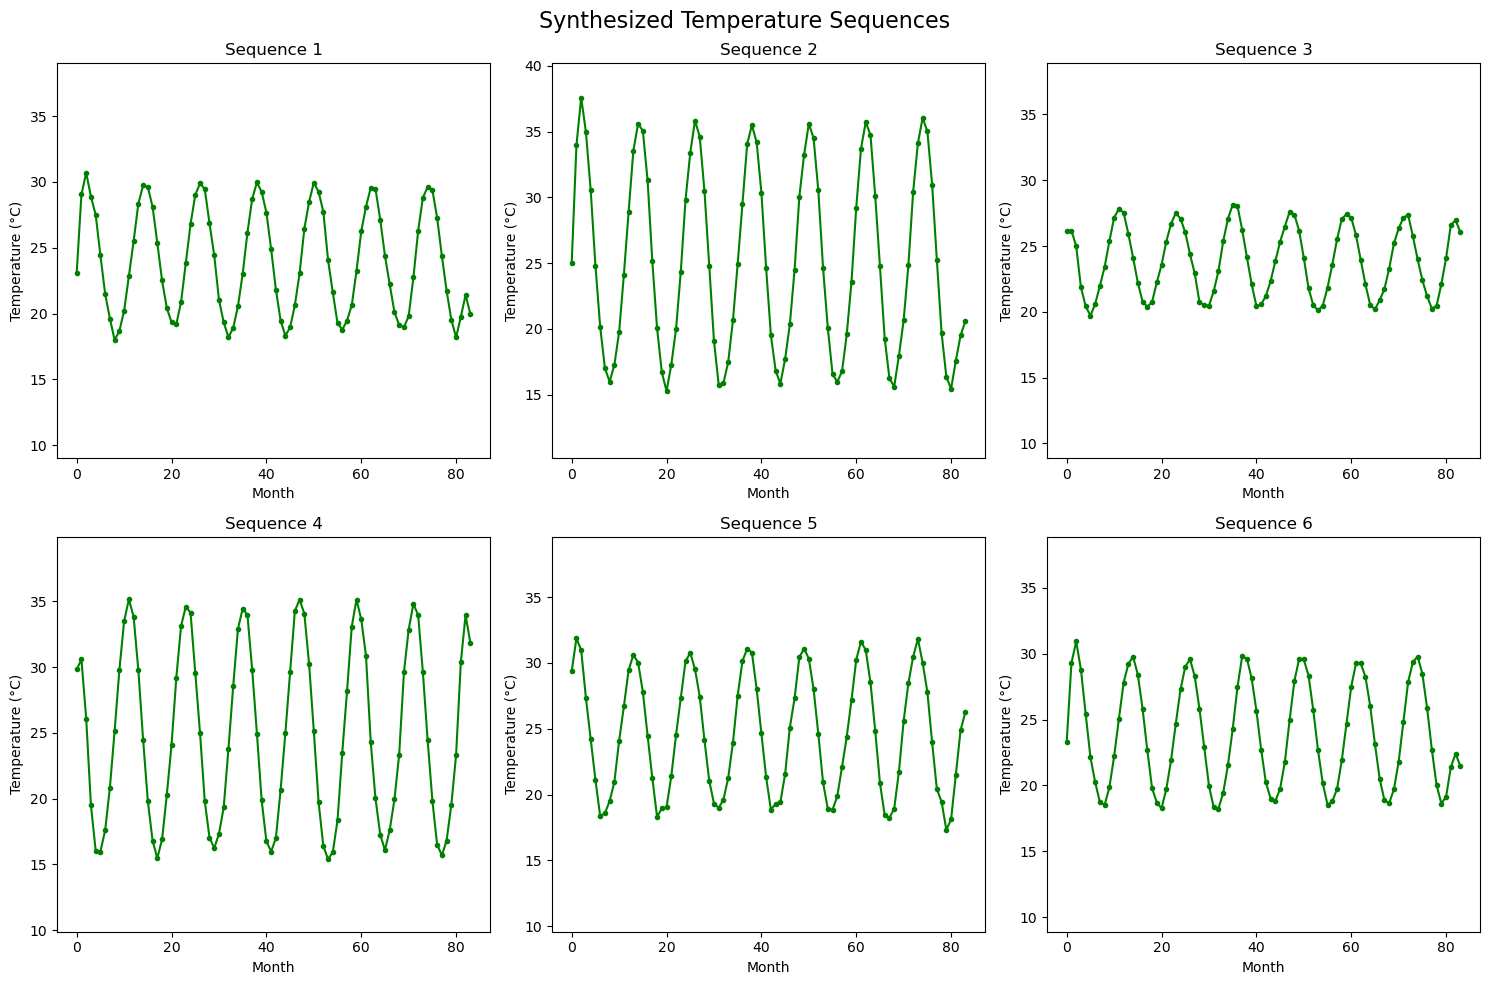

<Figure size 640x480 with 0 Axes>

In [220]:
num_sequences = 6
random_latent_points = tf.random.normal(shape=(num_sequences, codings_size))
    
# use vae decoder to generate temperature sequence
generated_sequences = decoder_vae.predict(random_latent_points,verbose=0)
# call the display_temperatures to plot generated sequencecs 
display_temperatures(generated_sequences)

- Periodicity: Showing clear periodic patterns, and each cycle spans approximately 12 months.
- Temperature range: Most temperature values indeed fluctuate between 18°C and 35°C.
- Some sequences (such as sequences 2) have maximum around 38, which is also reasonable.
- In general ,they are good, but lack short-term small-scale fluctuations (as seen in real temperature sequences).

# END